신호(시그널), 특히 디지털 신호와의 디지털 신호 샘플링, 양자화에 대해 알아본다. 또한 interference와 beating에 대해서도 다룬다.

In [79]:
import numpy as np
from scipy.interpolate import interp1d
import scipy
from matplotlib import pyplot as plt
import IPython.display as ipd
from IPython.display import Image
import librosa
from utils import *

# 디지털 신호 샘플링

아날로그 신호는 시간과 진폭 모두에서 연속적인 범위의 값을 가지므로 일반적으로 무한한 수의 값이 생성된다. 컴퓨터는 한정된 수의 값만 저장하고 처리할 수 있기 때문에 파형을 **이산** 표현, 즉 일반적으로 **디지털화**라고 하는 프로세스로 변환해야 한다. 오디오 신호를 디지털화하는 가장 일반적인 접근 방식은 **샘플링(sampling)** 및 **양자화(quantization)** 라는 두 단계로 구성된다.

## 샘플링

- 신호 처리(signal processing)에서, **샘플링**이란 연속 신호를 시간 축의 이산적 부분집합으로만 정의된 이산 신호로 축소시키는 것을 말한다. 
- 적절한 인코딩을 통해 이산 집합이 정수 집합 $\mathbb{Z}$의 하위 집합 $I$라고 가정하고는 한다. 그런 다음 DT(discrete time)-신호는 함수 $x\colon I\to\mathbb{R}$로 정의되며 여기서 도메인 $I$는 시점에 해당한다. 

- $\mathbb{Z}\setminus I$의 포인트에 대해 모든 값을 0으로 설정하는 것만으로 도메인 $I$에서 도메인 $\mathbb{Z}$로 모든 DT 신호를 확장할 수 있으므로 $I=\mathbb{Z}$를 가정할 수 있다.

- CT(continuous time)-신호 $f\colon\mathbb{R}\to\mathbb{R}$를 DT-신호 $x\colon\mathbb{Z}\to\mathbb{R}$로 변환하는 가장 일반적인 샘플링 절차는 **등거리 샘플링(equidistant sampling)**이라고 한다.

- 양의 실수 $T>0$를 고정하면, DT-신호 $x$는 다음과 같이 설정하여 얻는다.
    - $x(n):= f(n \cdot T)$ for $n\in\mathbb{Z}$

- $x(n)$ 값은 원래 아날로그 신호 $f$의 시간 $t=n\cdot T$에서 가져온 **샘플**이라고 한다. 간단히 말해서 이 절차를 **$T$-sampling** 이라고도 한다. 

- 숫자 $T$는 **샘플링 주기 (sampling period)** 라고 하고 역(inverse) $F_\mathrm{s}:=1/T$는 **샘플링 속도 (sampling rate)** 라고 한다. 샘플링 속도(레이트)는 초당 샘플 수를 지정하며 헤르츠(Hz) 단위로 측정된다.

- 다음 코드 셀에서 높은 샘플링 속도로 샘플링된 DT-신호의 선형 보간법을 통해 정의된 CT-신호 $f$로 시작한다. 그림에서 이 CT-신호는 검은색 곡선으로 표시된다. 등거리 샘플링을 적용하여 빨간색 줄기 플롯으로 시각화된 DT 신호 $x$를 얻는다.

In [80]:
def generate_function(Fs, dur=1):
    """Generate example function
    
    Args:
        Fs (scalar): Sampling rate
        dur (float): Duration (in seconds) of signal to be generated (Default value = 1)
        
    Returns:
        x (np.ndarray): Signal
        t (np.ndarray): Time axis (in seconds)
    """
    N = int(Fs * dur)
    t = np.arange(N) / Fs
    x = 1 * np.sin(2 * np.pi * (2 * t - 0))
    x += 0.5 * np.sin(2 * np.pi * (6 * t - 0.1))
    x += 0.1 * np.sin(2 * np.pi * (20 * t - 0.2))
    return x, t


def sampling_equidistant(x_1, t_1, Fs_2, dur=None):
    """Equidistant sampling of interpolated signal

    Args:
        x_1 (np.ndarray): Signal to be interpolated and sampled
        t_1 (np.ndarray): Time axis (in seconds) of x_1
        Fs_2 (scalar): Sampling rate used for equidistant sampling
        dur (float): Duration (in seconds) of sampled signal (Default value = None)
        
    Returns:
        x (np.ndarray): Sampled signal
        t (np.ndarray): Time axis (in seconds) of sampled signal
    """
    if dur is None:
        dur = len(t_1) * t_1[1]
    N = int(Fs_2 * dur)
    t_2 = np.arange(N) / Fs_2
    x_2 = interp1d(t_1, x_1, kind='linear', fill_value='extrapolate')(t_2)
    return x_2, t_2

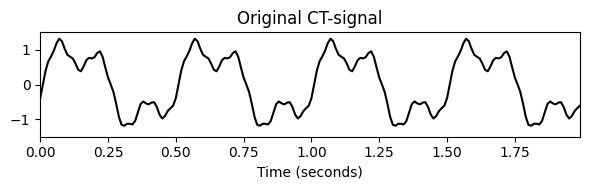

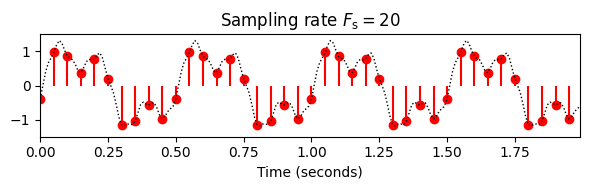

In [81]:
Fs_1 = 100
x_1, t_1 = generate_function(Fs=Fs_1, dur=2)

Fs_2 = 20
x_2, t_2 = sampling_equidistant(x_1, t_1, Fs_2)
    
plt.figure(figsize=(6, 2))
plt.plot(t_1, x_1, 'k')
plt.title('Original CT-signal')
plt.xlabel('Time (seconds)')
plt.ylim([-1.5, 1.5])
plt.xlim([t_1[0], t_1[-1]])
plt.tight_layout()

plt.figure(figsize=(6, 2))
plt.stem(t_2, x_2, linefmt='r', markerfmt='ro', basefmt='None')
plt.plot(t_1, x_1, 'k', linewidth=1, linestyle='dotted')
plt.title(r'Sampling rate $F_\mathrm{s} = %.0f$'%Fs_2)
plt.xlabel('Time (seconds)')
plt.ylim([-1.5, 1.5])
plt.xlim([t_1[0], t_1[-1]])
plt.tight_layout()

## 에일리어싱 (Aliasing)
또는 위신호현상

- 일반적으로 샘플링은 처리 과정에서 정보가 손실되고 원본 CT-신호를 샘플링된 버전으로부터 복구할 수 없다는 점에서 **손실(lossy)** 작업이다. 

- CT-신호에 주파수 스펙트럼 측면(**대역 제한(bandlimited)** 필요)에서 추가 속성이 있는 경우에만 완벽한 재구성이 가능하다. 이것이 유명한 **sampling theorem**의 주장이다. sampling theorem는 또한 DT-신호의 샘플에 의해 가중된 적절하게 이동된 $\mathrm{sinc}$-함수를 중첩하여 원래 CT-신호가 어떻게 재구성될 수 있는지 보여준다.

- 추가적인 속성이 없다면 샘플링으로 인해 신호의 특정 주파수 구성 요소를 구분할 수 없게 되는 **에일리어싱**이라는 현상이 발생할 수 있다.

- 이 효과는 다음 그림에 설명되어 있다. 높은 샘플링 속도를 사용하면 원본 CT-신호를 높은 정확도로 재구성할 수 있다. 그러나 샘플링 속도를 낮추면 더 높은 주파수 구성 요소가 잘 캡처되지 않고 원래 신호의 대략적인 근사치만 남는다.

In [82]:
def reconstruction_sinc(x, t, t_sinc):
    """Reconstruction from sampled signal using sinc-functions

    Args:
        x (np.ndarray): Sampled signal
        t (np.ndarray): Equidistant discrete time axis (in seconds) of x
        t_sinc (np.ndarray): Equidistant discrete time axis (in seconds) of signal to be reconstructed

    Returns:
        x_sinc (np.ndarray): Reconstructed signal having time axis t_sinc
    """
    Fs = 1 / t[1]
    x_sinc = np.zeros(len(t_sinc))
    for n in range(0, len(t)):
        x_sinc += x[n] * np.sinc(Fs * t_sinc - n)
    return x_sinc

def plot_signal_reconstructed(t_1, x_1, t_2, x_2, t_sinc, x_sinc):
    plt.figure(figsize=(6, 2))
    plt.plot(t_1, x_1, 'k', linewidth=1, linestyle='dotted', label='Orignal signal')
    plt.stem(t_2, x_2, linefmt='r:', markerfmt='r.', basefmt='None', label='Samples')
    plt.plot(t_1, x_sinc, 'b', label='Reconstructed signal')
    plt.title(r'Sampling rate $F_\mathrm{s} = %.0f$'%(1/t_2[1]))
    plt.xlabel('Time (seconds)')
    plt.ylim([-1.5, 1.5])
    plt.xlim([t_1[0], t_1[-1]])
    plt.legend(loc='upper right')
    plt.tight_layout()
    plt.show()

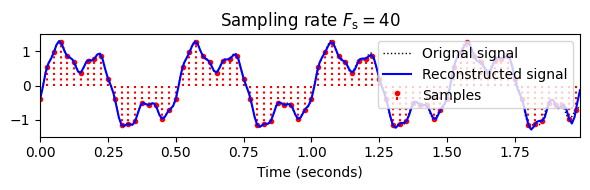

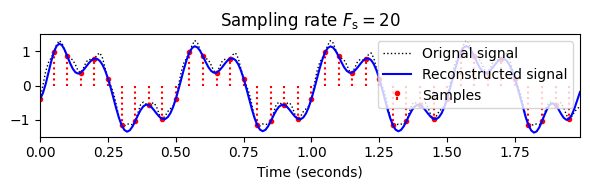

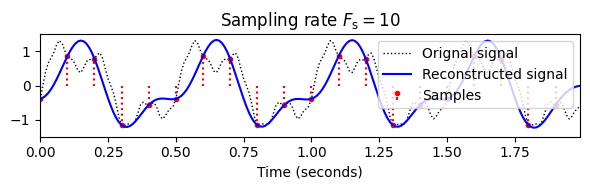

In [83]:
Fs_2 = 40
x_2, t_2 = sampling_equidistant(x_1, t_1, Fs_2)
t_sinc = t_1
x_sinc = reconstruction_sinc(x_2, t_2, t_sinc)
plot_signal_reconstructed(t_1, x_1, t_2, x_2, t_sinc, x_sinc);

Fs_2 = 20
x_2, t_2 = sampling_equidistant(x_1, t_1, Fs_2)
t_sinc = t_1
x_sinc = reconstruction_sinc(x_2, t_2, t_sinc)
plot_signal_reconstructed(t_1, x_1, t_2, x_2, t_sinc, x_sinc);

Fs_2 = 10
x_2, t_2 = sampling_equidistant(x_1, t_1, Fs_2)
t_sinc = t_1
x_sinc = reconstruction_sinc(x_2, t_2, t_sinc)
plot_signal_reconstructed(t_1, x_1, t_2, x_2, t_sinc, x_sinc);

- 다음 예는 에일리어싱이 음질에 미치는 영향을 나타낸다. 높은 샘플링 속도($F_s=8192Hz$)의 음악 신호로 시작한 다음 두배씩 줄여나가보자.

In [84]:
x, Fs = librosa.load('../audio/piano_c_scale.wav', sr=8000)
Fs_orig = Fs
len_orig = len(x)
for i in range(5):
    print('Sampling rate Fs = %s; Number of samples = %s' % (Fs, len(x)))
    x_play = scipy.signal.resample(x, len_orig)
    ipd.display(ipd.Audio(data=x_play, rate=Fs_orig))
    Fs = Fs // 2
    x = x[::2]

Sampling rate Fs = 8000; Number of samples = 54001


Sampling rate Fs = 4000; Number of samples = 27001


Sampling rate Fs = 2000; Number of samples = 13501


Sampling rate Fs = 1000; Number of samples = 6751


Sampling rate Fs = 500; Number of samples = 3376


## Sampling Theorem

- 샘플링 정리 **sampling theorem**는 대역 제한이 있는(bandlimited) 연속 시간(CT) 신호를 특정 조건에서 완벽하게 재구성할 수 있다고 말한다. 

- 보다 정확하게는 $|\omega|>\Omega$ 에 대해 푸리에 변환 $\hat{f}$가 사라지면 CT 신호 $f\in L^2(\mathbb{R})$를 **$\Omega$-bandlimited** 라고 한다 (즉, $\hat{f}(\omega) = 0$ for $|\omega|>\Omega$).

- $f\in L^2(\mathbb{R})$를 $\Omega$-bandlimited 함수라고 하고, $x$를 $f$의 (with $T:=1/(2\Omega)$) $T$-샘플 버전이라고 하자 (즉, $x(n)=f(nT)$, $n\in\mathbb{Z}$).

- 그러면 $f$는 다음과 같이 $x$로부터 재구성될 수 있다.

$$
 f(t)=\sum_{n\in\mathbb{Z}}x(n)\mathrm{sinc}\left(\frac{t-nT}{T}\right)
 =\sum_{n\in\mathbb{Z}}f\left(\frac{n}{2\Omega}\right) \mathrm{sinc}\left(2\Omega t-n\right),
$$

where the $\mathrm{sinc}$-function is defined as

\begin{equation}
    \mathrm{sinc}(t):=\left\{\begin{array}{ll}
    \frac{\sin \pi t}{\pi t},&\mbox{ if $t\not= 0$,}\\
    1,&\mbox{ if $t= 0$.}
\end{array}\right.
\end{equation}

- 즉, 대역 제한이 샘플링 속도의 절반 이하인 경우, 등거리 샘플링으로 얻은 DT 신호에서 CT 신호 $f$를 완벽하게 재구성할 수 있다. 
- $\mathrm{sinc}$ 함수를 기반으로 한 이 재구성은 `reconstruction_sinc` 함수에서 사용되었다.

# 디지털 신호 양자화 (Quantization)

## 이산화 Discretization

- 위에서 연속-시간 축을 이산-시간 축으로 변환하는 과정으로서의 샘플링을 보았다. 이것은 아날로그-투-디지털의 첫번째 단계였다.

- 두 번째 단계에서는 가능한 진폭(amplitude)의 연속 범위($\mathbb{R}$로 인코딩됨)를 가능한 값의 이산 범위(이산 집합 $\Gamma\subset \mathbb{R}$로 인코딩됨)로 대체해야 한다. 이 프로세스를 일반적으로 **양자화(quantization)** 라고 한다.

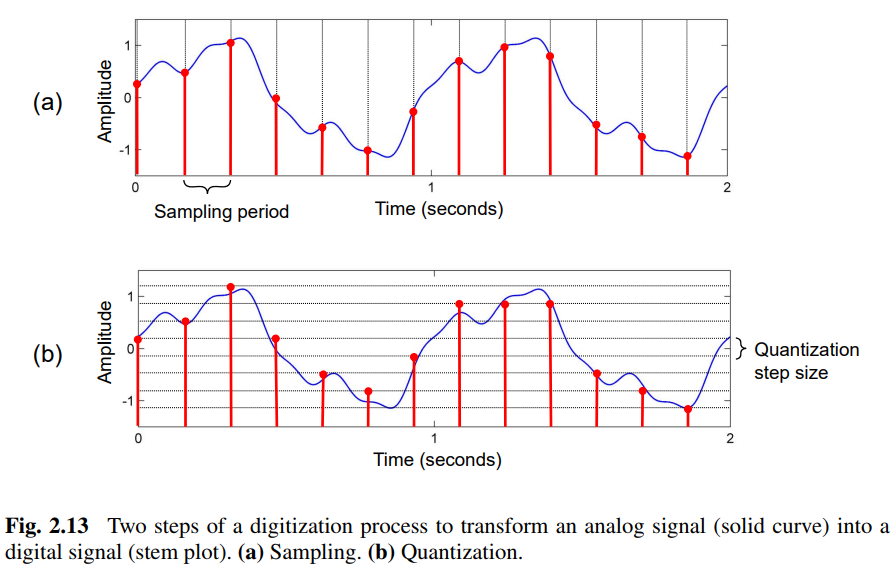

In [85]:
Image('../img/3.fourier_analysis/f.2.13.PNG', width=500)

## Uniform 양자화

- 양자화는 각 진폭 값 $a\in\mathbb{R}$에 값 $Q(a)\in\Gamma$을 할당하는 **quantizer**라고 하는 함수 $Q:\mathbb{R}\to\Gamma$로 모델링할 수 있다. 

- 사용되는 많은 quantizer는 단순히 아날로그 값을 일부 정밀도 단위로 반올림하거나 자른다(truncate). 예를 들어 어떤 값 $\Delta$와 동일한 **quantization step size**를 갖는 일반적인 **uniform** quantizer는 양자화 수준을 균일하게 배치한다.
    - $Q(a) := \mathrm{sgn}(a) \cdot \Delta \cdot \left\lfloor \frac{|a|}{\Delta} + \frac{1}{2} \right\rfloor$ for $a\in\mathbb{R}$, 
    - $\mathrm{sgn}(\cdot)$는 실수의 부호를 생성하는 signum 함수이며, 대괄호 $\lfloor \cdot \rfloor$는 실수를 잘라(truncate) 이 숫자 아래에서 가장 큰 정수를 생성하는 것이다.
    - $\Delta=1$의 경우 quantizer $Q$는 가장 가까운 정수로 간단히 반올림된다.

### 양자화 오류 Quantization Error

- 샘플링과 마찬가지로 양자화는 일반적으로 손실이 많은 작업이다. 다른 아날로그 값이 동일한 디지털 값에 매핑될 수 있기 때문이다. 실제 아날로그 값과 양자화된 값의 차이를 **양자화 오류**라고 한다. 

- 양자화 step size $\Delta$를 줄이면 일반적으로 양자화 오류가 더 작아진다. 그러나 동시에 양자화된 값의 수(따라서 이러한 값을 인코딩하는 데 필요한 비트 수)도 증가한다. 
- 예를 들어 양자화 단계 크기 $\Delta=1/3$가 사용되면 주어진 신호에 대해 $8$의 서로 다른 양자화 값이 생성된다. 따라서 $3$ 비트 코딩 방식을 사용하여 양자화된 값을 나타낼 수 있다. CD 녹음의 경우 $65536$ 가능한 값을 표현할 수 있는 $16$ 비트 코딩 체계가 사용된다.

### Uniform 양자화 실행

- 다음에서 모든 아날로그 값이 $s,t\in\mathbb{R}$에 대해 $[s,t]$ 범위 내에 있다고 가정한다. 또한 여러 양자화 수준이 $\lambda\in\mathbb{N}$인 경우, 양자화 step size를 $\Delta=|t-s|/(\lambda-1)$로 정의한다. 이는 $\lambda$ 양자화 레벨로 구성되는 ($s$ 값으로 시작하여 $t$ 값으로 끝남), 값 $s$와 $t$ 사이의 uniform 양자화로 정의한다.
- 예를 들어 파형 기반 오디오 신호는 일반적으로 $[-1,1]$ 범위에 있다.
- $s=-1$, $t=1$ 및 $\lambda=9$의 경우 결과는 $\Delta=1/4$이다. 이 경우 결과 양자화 오류는 최대 1/8입니다. 다음 코드 셀에서 서로 다른 매개변수 $s$, $t$ 및 $\lambda$에 대해 균일한 양자화를 산출하는 `quantize_uniform` 함수를 정의해보자.

In [86]:
def quantize_uniform(x, quant_min=-1.0, quant_max=1.0, quant_level=5):
    """Uniform quantization approach

    Args:
        x (np.ndarray): Original signal
        quant_min (float): Minimum quantization level (Default value = -1.0)
        quant_max (float): Maximum quantization level (Default value = 1.0)
        quant_level (int): Number of quantization levels (Default value = 5)

    Returns:
        x_quant (np.ndarray): Quantized signal
    """
    x_normalize = (x-quant_min) * (quant_level-1) / (quant_max-quant_min)
    x_normalize[x_normalize > quant_level - 1] = quant_level - 1
    x_normalize[x_normalize < 0] = 0
    x_normalize_quant = np.around(x_normalize)
    x_quant = (x_normalize_quant) * (quant_max-quant_min) / (quant_level-1) + quant_min
    return x_quant


def plot_graph_quant_function(ax, quant_min=-1.0, quant_max=1.0, quant_level=256, mu=255.0, quant='uniform'):
    """Helper function for plotting a graph of quantization function and quantization error

    Args:
        ax (mpl.axes.Axes): Axis
        quant_min (float): Minimum quantization level (Default value = -1.0)
        quant_max (float): Maximum quantization level (Default value = 1.0)
        quant_level (int): Number of quantization levels (Default value = 256)
        mu (float): Encoding parameter (Default value = 255.0)
        quant (str): Type of quantization (Default value = 'uniform')
    """
    x = np.linspace(quant_min, quant_max, 1000)
    if quant == 'uniform':
        x_quant = quantize_uniform(x, quant_min=quant_min, quant_max=quant_max, quant_level=quant_level)
        quant_stepsize = (quant_max - quant_min) / (quant_level-1)
        title = r'$\lambda = %d, \Delta=%0.2f$' % (quant_level, quant_stepsize)
    if quant == 'nonuniform':
        x_quant = quantize_nonuniform_mu(x, mu=mu, quant_level=quant_level)
        title = r'$\lambda = %d, \mu=%0.1f$' % (quant_level, mu)
    error = np.abs(x_quant - x)
    ax.plot(x, x, color='k', label='Original amplitude')
    ax.plot(x, x_quant, color='b', label='Quantized amplitude')
    ax.plot(x, error, 'r--', label='Quantization error')
    ax.set_title(title)
    ax.set_xlabel('Amplitude')
    ax.set_ylabel('Quantized amplitude/error')
    ax.set_xlim([quant_min, quant_max])
    ax.set_ylim([quant_min, quant_max])
    ax.grid('on')
    ax.legend()

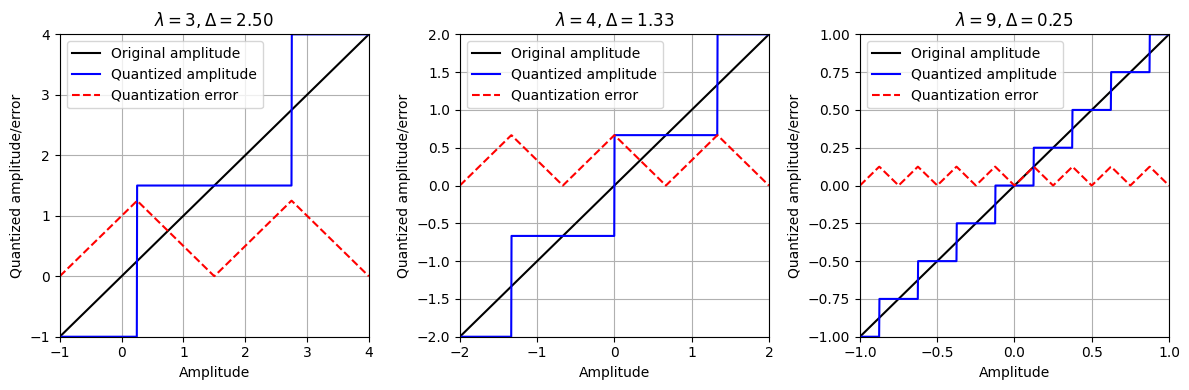

In [87]:
plt.figure(figsize=(12,4))
ax = plt.subplot(1, 3, 1)
plot_graph_quant_function(ax, quant_min=-1, quant_max=4, quant_level=3)
ax = plt.subplot(1, 3, 2)
plot_graph_quant_function(ax, quant_min=-2, quant_max=2, quant_level=4)
ax = plt.subplot(1, 3, 3)
plot_graph_quant_function(ax, quant_min=-1, quant_max=1, quant_level=9)
plt.tight_layout()
plt.show()

- 다음 코드 셀에서는 정현파를 신호로 사용하여 다양한 파라미터 설정에 대한 균일(uniform) 양자화 결과를 본다.

In [88]:
def generate_sinusoid(dur=5, Fs=1000, amp=1, freq=1, phase=0):
    """Generation of sinusoid
    
    2.3.Audio_Represenation에 쓰인 바 있음
    
    Args:
        dur (float): Duration (in seconds) (Default value = 5)
        Fs (scalar): Sampling rate (Default value = 1000)
        amp (float): Amplitude of sinusoid (Default value = 1)
        freq (float): Frequency of sinusoid (Default value = 1)
        phase (float): Phase of sinusoid (Default value = 0)
    Returns:
        x (np.ndarray): Signal
        t (np.ndarray): Time axis (in seconds)
    """
    num_samples = int(Fs * dur)
    t = np.arange(num_samples) / Fs
    x = amp * np.sin(2*np.pi*(freq*t-phase))
    return x, t


def plot_signal_quant(x, t, x_quant, figsize=(6, 2), xlim=None, ylim=None, title=''):
    """Helper function for plotting a signal and its quantized version

    Args:
        x: Original Signal
        t: Time
        x_quant: Quantized signal
        figsize: Figure size (Default value = (8, 2))
        xlim: Limits for x-axis (Default value = None)
        ylim: Limits for y-axis (Default value = None)
        title: Title of figure (Default value = '')
    """
    plt.figure(figsize=figsize)
    plt.plot(t, x, color='gray', linewidth=1.0, linestyle='-', label='Original signal')
    plt.plot(t, x_quant, color='red', linewidth=2.0, linestyle='-', label='Quantized signal')
    if xlim is None:
        plt.xlim([0, t[-1]])
    else:
        plt.xlim(xlim)
    if ylim is not None:
        plt.ylim(ylim)
    plt.xlabel('Time (seconds)')
    plt.ylabel('Amplitude')
    plt.title(title)
    plt.legend(loc='upper right', framealpha=1)
    plt.tight_layout()
    plt.show()

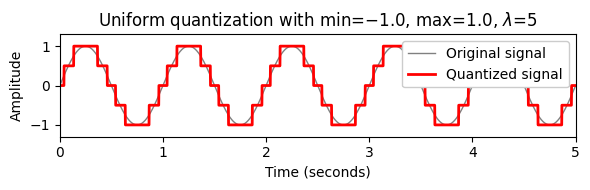

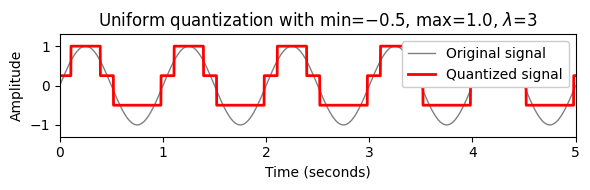

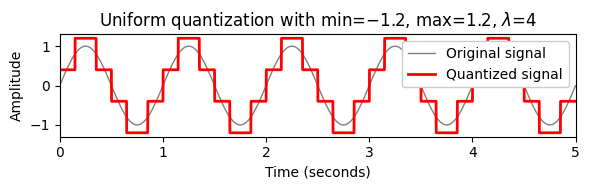

In [89]:
dur = 5
x, t = generate_sinusoid(dur=dur, Fs=1000, amp=1, freq=1, phase=0.0)

quant_min = -1
quant_max = 1
quant_level = 5
x_quant = quantize_uniform(x, quant_min=quant_min, quant_max=quant_max, 
                          quant_level=quant_level)
plot_signal_quant(x, t, x_quant, xlim=[0, dur], ylim=[-1.3,1.3], 
                  title=r'Uniform quantization with min=$%0.1f$, max=$%0.1f$, $\lambda$=$%d$'%(quant_min, quant_max, quant_level));

quant_min = -0.5
quant_max = 1
quant_level = 3
x_quant = quantize_uniform(x, quant_min=quant_min, quant_max=quant_max, 
                          quant_level=quant_level)
plot_signal_quant(x, t, x_quant, xlim=[0, dur], ylim=[-1.3,1.3], 
                  title=r'Uniform quantization with min=$%0.1f$, max=$%0.1f$, $\lambda$=$%d$'%(quant_min, quant_max, quant_level));

quant_min = -1.2
quant_max = 1.2
quant_level = 4
x_quant = quantize_uniform(x, quant_min=quant_min, quant_max=quant_max, 
                          quant_level=quant_level)
plot_signal_quant(x, t, x_quant, xlim=[0, dur], ylim=[-1.3,1.3], 
                  title=r'Uniform quantization with min=$%0.1f$, max=$%0.1f$, $\lambda$=$%d$'%(quant_min, quant_max, quant_level));

## Nonuniform Quantization

- uniform 양자화에서 양자화 수준은 **등거리 (equidistant)** 방식으로 배치(spaced)된다. 그렇지 않은 경우 **비균일 (nonuniform)** 양자화라고 한다. 예를 들어 오디오 신호의 경우 **logarithmic(대수적)** 방식으로 간격을 둔 양자화 수준을 선택하는 경우가 많다. 소리 강도에 대한 인간의 인식이 본질적으로 대수적이기 때문이다.
- 따라서 인지적 관점에서 보면 높은 진폭 값을 인코딩하는 것보다 낮은 진폭 값을 인코딩하는 데 더 많은 비트를 활용하는 것이 유리할 수 있다(낮은 진폭 값에서 인간은 소리 강도의 변화에 더 민감함). 

- 로그 양자화에 대한 한 가지 접근 방식으로 다음과 같이 정의되는 **$\mu$-law** 인코딩이 있다.
    - $F_\mu(v) = \mathrm{sgn}(v) \frac{\ln(1+ \mu |v|)}{\ln(1+\mu)}$
    - for values $v\in[-1,1]$, where $\mathrm{sgn}$ denotes the signum function
- 파라미터 $\mu\in\mathbb{R}_{>0}$는 적용되는 compression 정도를 결정하는 정수이다. 
- 실제로는 비균일 $8$비트 양자화 체계를 도출하기 위해 $\mu=255$를 자주 사용한다. 인코딩 $F_\mu$는 strictly 증가 단조 함수로, $[-1,1]$ 간격을 낮은 값은 확장되고 높은 값은 압축되도록 자기 자체에 매핑한다. 
- 그 역인 **$\mu$-law 디코딩(decoding)** 은 다음과 같다.
    - $F_\mu^{-1}(v) = \mathrm{sgn}(v) \frac{(1 + \mu)^{|v|}- 1}{\mu}$ for values $v\in[-1,1]$. 
    
- 다음 코드 셀에서 $F_\mu$ 함수와 그 역 $F_\mu^{-1}$를 구현하고 다른 파라미터 $\mu$에 대한 행동을 설명한다.

In [90]:
def encoding_mu_law(v, mu=255.0):
    """mu-law encoding

    Args:
        v (float): Value between -1 and 1
        mu (float): Encoding parameter (Default value = 255.0)

    Returns:
        v_encode (float): Encoded value
    """
    v_encode = np.sign(v) * (np.log(1.0 + mu * np.abs(v)) / np.log(1.0 + mu))
    return v_encode


def decoding_mu_law(v, mu=255.0):
    """mu-law decoding

    Args:
        v (float): Value between -1 and 1
        mu (float): Dencoding parameter (Default value = 255.0)

    Returns:
        v_decode (float): Decoded value
    """
    v_decode = np.sign(v) * (1.0 / mu) * ((1.0 + mu)**np.abs(v) - 1.0)
    return v_decode

In [91]:
def plot_mu_law(mu=255.0, figsize=(8, 3)):
    """Helper function for plotting a signal and its quantized version

    Args:
        mu (float): Dencoding parameter (Default value = 255.0)
        figsize (tuple): Figure size (Default value = (8.5, 2))
    """
    values = np.linspace(-1, 1, 1000)
    values_encoded = encoding_mu_law(values, mu=mu)
    values_decoded = encoding_mu_law(values, mu=mu)

    plt.figure(figsize=figsize)
    ax = plt.subplot(1, 2, 1)
    ax.plot(values, values, color='k', label='Original values')
    ax.plot(values, values_encoded, color='b', label='Encoded values')
    ax.set_title(r'$\mu$-law encoding with $\mu=%.0f$' % mu)
    ax.set_xlabel('$v$')
    ax.set_ylabel(r'$F_\mu(v)$')
    ax.set_xlim([-1, 1])
    ax.set_ylim([-1, 1])
    ax.grid('on')
    ax.legend()

    ax = plt.subplot(1, 2, 2)
    ax.plot(values, values, color='k', label='Original values')
    ax.plot(values, values_decoded, color='b', label='Decoded values')
    ax.set_title(r'$\mu$-law decoding with $\mu=%.0f$' % mu)
    ax.set_xlabel('$v$')
    ax.set_ylabel(r'$F_\mu^{-1}(v)$')
    ax.set_xlim([-1, 1])
    ax.set_ylim([-1, 1])
    ax.grid('on')
    ax.legend()

    plt.tight_layout()
    plt.show()

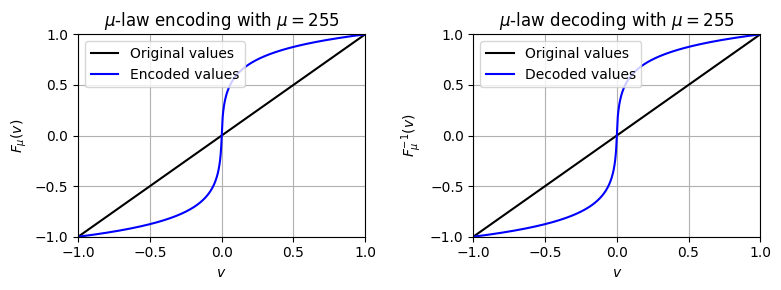

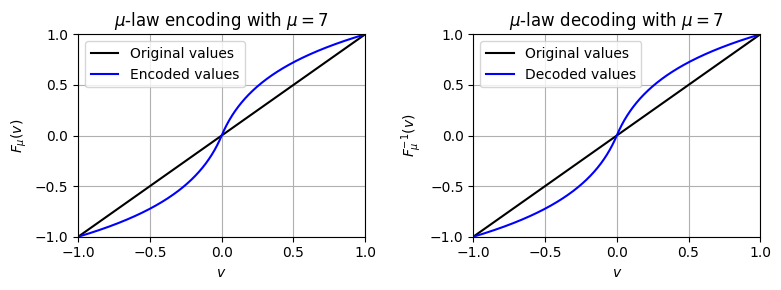

In [92]:
plot_mu_law(mu=255.0)
plot_mu_law(mu=7.0)

### Nonuniform 양자화 실행

- 먼저 주어진 신호를 $F_\mu$를 사용하여 인코딩한 다음, 균일 양자화를 적용하고, 마지막으로 $F_\mu^{-1}$를 사용하여 양자화된 신호를 디코딩해보자. 다음 코드에서 신호 샘플을 $[-1,1]$ 범위에 있는 경우로 제한한다. 뒤의 그림은 위의 정현파 예제 형식을 따르는 균일 양자화와 비균일 양자화의 차이를 보여준다.

In [93]:
def quantize_nonuniform_mu(x, mu=255.0, quant_level=256):
    """Nonuniform quantization approach using mu-encoding

    Args:
        x (np.ndarray): Original signal
        mu (float): Encoding parameter (Default value = 255.0)
        quant_level (int): Number of quantization levels (Default value = 256)

    Returns:
        x_quant (np.ndarray): Quantized signal
    """
    x_en = encoding_mu_law(x, mu=mu)
    x_en_quant = quantize_uniform(x_en, quant_min=-1, quant_max=1, quant_level=quant_level)
    x_quant = decoding_mu_law(x_en_quant, mu=mu)
    return x_quant

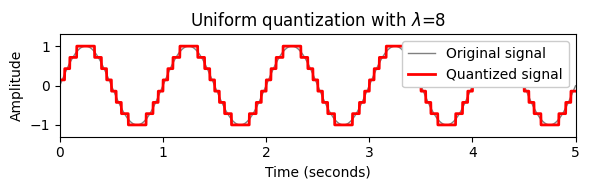

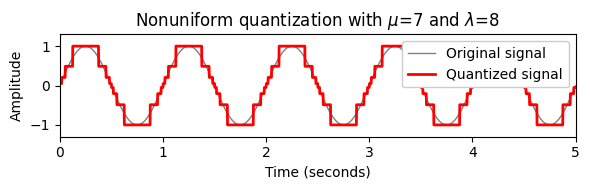

In [94]:
dur = 5
x, t = generate_sinusoid(dur=dur, Fs=1000, amp=1, freq=1, phase=0.0)

quant_level = 8
x_quant = quantize_uniform(x, quant_min=-1, quant_max=1, quant_level=quant_level)
plot_signal_quant(x, t, x_quant, xlim=[0, dur], ylim=[-1.3,1.3], 
title=r'Uniform quantization with $\lambda$=$%d$'%(quant_level));

mu = 7
x_quant = quantize_nonuniform_mu(x, mu=mu, quant_level=quant_level)
plot_signal_quant(x, t, x_quant, xlim=[0, dur], ylim=[-1.3,1.3], 
title=r'Nonuniform quantization with $\mu$=$%d$ and $\lambda$=$%d$'%(mu, quant_level));

- 위의 접근 방식은 두 개의 파라미터, $\mu$(인코딩 파라미타) 및 $\lambda$(간격 $[-1,1]$의 양자화 레벨 수)에 따라 달라지는 비균일 양자화 함수를 생성한다. 다음 코드 셀에서는 다양한 파라미터 설정에 대한 양자화 오류(quantization error)와 양자화 함수의 그래프를 보여준다. 양자화 오류는 $|v|\approx 1$인 $v$ 값보다 $|v|\approx 0$인 $v$ 값에서 훨씬 더 낮다.

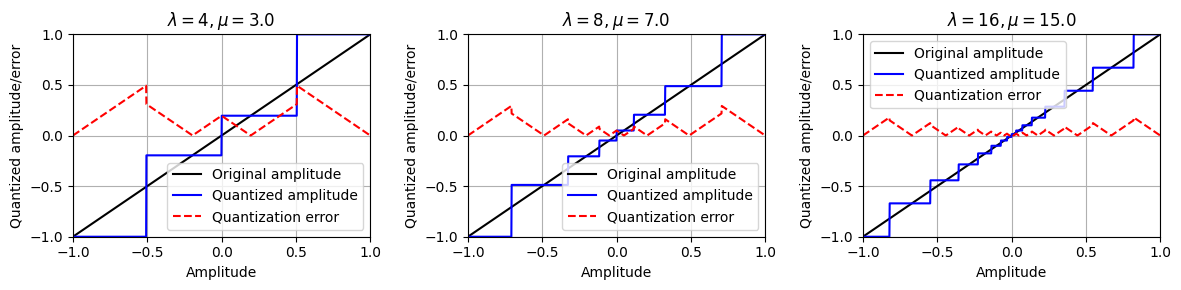

In [95]:
plt.figure(figsize=(12,3))
ax = plt.subplot(1, 3, 1)
plot_graph_quant_function(ax, mu=3, quant_level=4, quant='nonuniform')
ax = plt.subplot(1, 3, 2)
plot_graph_quant_function(ax, mu=7, quant_level=8, quant='nonuniform')
ax = plt.subplot(1, 3, 3)
plot_graph_quant_function(ax, mu=15, quant_level=16, quant='nonuniform')
plt.tight_layout()
plt.show()

## 양자화 잡음 (Quantization Noise)

- 신호의 양자화는 손실이 많은 작업이다. 이 과정에서 발생하는 왜곡을 **양자화 잡음**이라고 한다. 다음 코드 셀에서 샘플 값을 인코딩하기 위해 다른 수의 비트를 사용하여 C 메이저 음계의 피아노 녹음을 양자화하여 이러한 왜곡의 인상(impression)을 줘본다. $b\in\mathbb{N}$ 비트를 사용하여 $2^b$의 서로 다른 양자화 레벨을 인코딩할 수 있다.

In [96]:
def display_signal_quant(x, Fs, number_of_bits):
    quant_level = 2 ** number_of_bits
    x_quant = quantize_uniform(x, quant_min=-1, quant_max=1, quant_level=quant_level)    
    print('Signal after uniform quantization (%d bits) :'%number_of_bits, flush=True)
    ipd.display(ipd.Audio(x_quant, rate=Fs))
    return x_quant

In [97]:
x, Fs = librosa.load("../audio/piano_c_scale.wav", sr=11025)

print('Original audio signal (16 bits):', flush=True)
ipd.display(ipd.Audio(x, rate=Fs) )

x_quant = display_signal_quant(x=x, Fs=Fs, number_of_bits=8)
x_quant = display_signal_quant(x=x, Fs=Fs, number_of_bits=4)
x_quant = display_signal_quant(x=x, Fs=Fs, number_of_bits=2)

Original audio signal (16 bits):


Signal after uniform quantization (8 bits) :


Signal after uniform quantization (4 bits) :


Signal after uniform quantization (2 bits) :


### Uniform 및 Nonuniform 양자화에 대한 양자화 노이즈

- 위의 C 메이저 스케일의 피아노 녹음을 사용하여 **양자화 노이즈** 결과 uniform 및 nonuniform 양자화를 비교한다. 샘플 값을 인코딩하기 위해 서로 다른 비트 수를 고려한다. 특히, $8$ 비트 균일 양자화를 사용할 때보다 $8$ 비트 비균일 양자화를 사용할 때 더 낮은 노이즈 레벨을 인지한다.

In [98]:
def compare_quant_signal(x, Fs, number_of_bits):
    quant_level = 2 ** number_of_bits
    mu = quant_level-1
    x_qu = quantize_uniform(x, quant_min=-1, quant_max=1, quant_level=quant_level)    
    x_qn = quantize_nonuniform_mu(x, mu=mu, quant_level=quant_level)
    audio_player_list([x, x_qu, x_qn], [Fs, Fs, Fs], width=160, 
                columns=['Original (16 bits)', 'Uniform (%d bits)'%number_of_bits, 'Nonuniform (%d bits)'%number_of_bits])

In [99]:
x, Fs = librosa.load("../audio/piano_c_scale.wav", sr=11025)

compare_quant_signal(x, Fs, number_of_bits=8)
compare_quant_signal(x, Fs, number_of_bits=4)
compare_quant_signal(x, Fs, number_of_bits=2)

# 간섭 및 비팅 (Interference and Beating)

## 간섭(Interference)

- 신호 처리에서 **간섭**은 한 파동이 비슷한 주파수의 다른 파동과 중첩(superimposed)될 때 발생한다. 한 파동의 파고(crest)가 어떤 지점에서 다른 파동의 파고와 만나면 일정 기간 동안 개별적 크기가 합산되며 이를 **constructive interference**이라고 한다. 반대로, 한 파동의 파고가 다른 파동의 파고와 만나면 크기가 일정 시간 동안 상쇄되는데, 이를 **destructive interference**이라고 한다.

In [100]:
def plot_interference(x1, x2, t, figsize=(6, 2), xlim=None, ylim=None, title=''):
    """Helper function for plotting two signals and its superposition
    Args:
        x1: Signal 1
        x2: Signal 2
        t: Time
        figsize: figure size (Default value = (8, 2))
        xlim: x limits (Default value = None)
        ylim: y limits (Default value = None)
        title: figure title (Default value = '')
    """
    plt.figure(figsize=figsize)
    plt.plot(t, x1, color='gray', linewidth=.5, linestyle='-', label='x1', alpha=.6)
    plt.plot(t, x2, color='cyan', linewidth=.5, linestyle='-', label='x2', alpha=.6)
    plt.plot(t, x1+x2, color='red', linewidth=1.0, linestyle='-', label='x1+x2', alpha=.6)
    if xlim is None:
        plt.xlim([0, t[-1]])
    else:
        plt.xlim(xlim)
    if ylim is not None:
        plt.ylim(ylim)
    plt.xlabel('Time (seconds)')
    plt.ylabel('Amplitude')
    plt.title(title)
    plt.legend(loc='upper right')
    plt.tight_layout()
    plt.show()

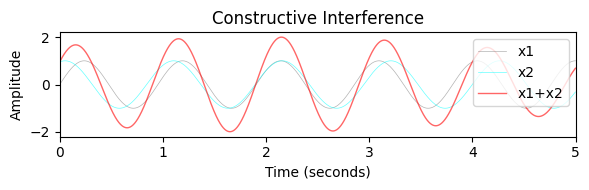

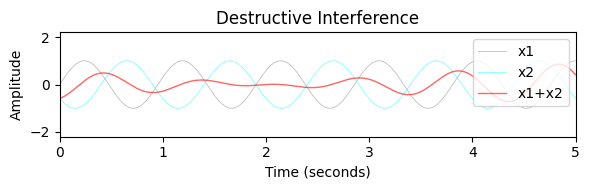

In [101]:
dur = 5
x1, t = generate_sinusoid(dur=dur, Fs=1000, amp=1, freq=1.05, phase=0.0)
x2, t = generate_sinusoid(dur=dur, Fs=1000, amp=1, freq=0.95, phase=0.8)
plot_interference(x1, x2, t, xlim=[0, dur], ylim=[-2.2,2.2], title='Constructive Interference');

dur = 5
x1, t = generate_sinusoid(dur=dur, Fs=1000, amp=1, freq=1.05, phase=0.0)
x2, t = generate_sinusoid(dur=dur, Fs=1000, amp=1, freq=1.00, phase=0.4)
plot_interference(x1, x2, t, xlim=[0, dur], ylim=[-2.2,2.2], title='Destructive Interference');

## Beating

- 앞의 그림은 주파수가 비슷한 두 정현파가 더해지거나(보강 간섭) 상쇄(상쇄 간섭)될 수 있음을 보여주었다. 

- $f_1(t)=\sin(2\pi \omega_1 t)$ 및 $f_2(t)=\sin(2\pi \omega_2 t)$를 뚜렷하지만 가까운 주파수 $\omega_1\approx\omega_2$의 두 정현파라고 하자.

- 이제 이 두 정현파의 중첩 $f_1+f_2$가 진폭이 천천히 변하는 단일 사인파처럼 보이는 함수를 생성한다는 것을 볼 수 있다. 이 현상은 **beating (비팅)** 이라고 한다. 수학적으로 이 현상은 **삼각 항등식 trigonometric identity**의 결과이다.
    - $
\sin(2\pi \omega_1t)+\sin(2\pi \omega_2t)=
2\cos\left(2\pi\frac{\omega_1-\omega_2}{2}t\right)\sin\left(2\pi\frac{\omega_1+\omega_2}{2}t\right).
$

- $\omega_1-\omega_2$의 차이가 작으면 코사인 항은 사인 항에 비해 빈도가 낮다. 

- 결과적으로 신호 $f_1+f_2$는 주파수 $|\omega_1-\omega_2|$의 천천히 변하는 진폭 포락선(amplitude envelope)을 가지는 주파수 $(\omega_1+\omega_2)/2$의 사인파로 볼 수 있다. 

- 이 비율은 코사인 항의 빈도 $(\omega_1-\omega_2)/2$의 두 배이다. 

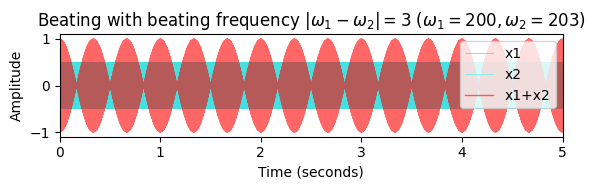

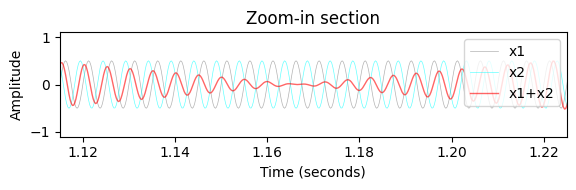

In [102]:
Fs = 4000
dur = 5
x1, t = generate_sinusoid(dur=dur, Fs=Fs, amp=0.5, freq=200)
x2, t = generate_sinusoid(dur=dur, Fs=Fs, amp=0.5, freq=203)
plot_interference(x1, x2, t, ylim=[-1.1,1.1], xlim=[0, dur],
    title=r'Beating with beating frequency $|\omega_1-\omega_2|=3$ ($\omega_1=200, \omega_2=203$)');
plot_interference(x1, x2, t, ylim=[-1.1,1.1], xlim=[1.115, 1.225], title=r'Zoom-in section');

ipd.display(ipd.Audio(x1+x2, rate=Fs))

### 처프(Chirp) 실험

- 비팅(beating)효과를 설명하기 위해 처프 신호(시간에 따라 주파수가 증가)를 보자.
- $\omega_0,\omega_1\in\mathbb{R}$를 두 주파수 파라미터(헤르츠 단위)라고 하고, $T\in\mathbb{R}$를 듀레이션 파라미터(초단위)라고 하자.
- $\omega_0$에서 시작하여 $\omega_1$로 주파수가 선형적으로 증가하는 듀레이션 $d$의 **선형 처프**는 다음과 같이 계산된다.
    - $ f(t)=\sin\left(\pi\frac{\omega_1-\omega_0}{T} t^2 + 2\pi\omega_0t\right)$ for $t\in[0,T]$
- 시간 $t$에서 처프 신호 $f$의 **순간 주파수 (instantaneous frequency)** 는 정현파의 인수를 $2\pi$로 나눈 것의 도함수로 주어진다.

$$
   g(t) = \frac{\omega_1-\omega_0}{T} t + \omega_0.
$$

- 주파수 $\omega_0=220.0~\mathrm{Hz}$(피치 $\mathrm{A3}$)에서 시작하여 주파수 $\omega_1=311.1~\mathrm{Hz}$(피치 $\mathrm{E}^\flat 4$)로 끝나는 듀레이션 $T=20~\mathrm{sec}$의 선형 처프 신호를 보자.

- 또한 동일한 듀레이션의 주파수 $261.5~\mathrm{Hz}$(피치 $\mathrm{C4}$)를 갖는 정현파를 생각해보자. 

- 이 신호의 중첩을 들을 때, 처음에는 $\mathrm{A3}$ 및 $\mathrm{C4}$ 두 개의 개별 피치를 인식한다. 

- 처프가 $\mathrm{C4}$에 가까워지면 두 음이 하나의 소리로 합쳐지기 시작한다. 동시에 처음에는 속도가 느려졌다가 사라지고(처프가 $\mathrm{C4}$에 도달하면), 다시 속도가 빨라지는 비팅 효과를 볼 수 있다. 마지막에 다시 $\mathrm{E}^\flat 4$ 및 $\mathrm{C4}$인 두 피치를 인식한다.


In [103]:
def generate_chirp_linear(dur, freq_start, freq_end, amp=1.0, Fs=22050):
    """Generation chirp with linear frequency increase

    Args:
        dur (float): Duration (seconds) of the signal
        freq_start (float): Start frequency of the chirp
        freq_end (float): End frequency of the chirp
        amp (float): Amplitude of chirp (Default value = 1.0)
        Fs (scalar): Sampling rate (Default value = 22050)

    Returns:
        x (np.ndarray): Generated chirp signal
        t (np.ndarray): Time axis (in seconds)
        freq (np.ndarray): Instant frequency (in Hz)
    """
    N = int(dur * Fs)
    t = np.arange(N) / Fs
    a = (freq_end - freq_start) / dur
    freq = a * t + freq_start
    x = amp * np.sin(np.pi * a * t ** 2 + 2 * np.pi * freq_start * t)
    return x, t, freq

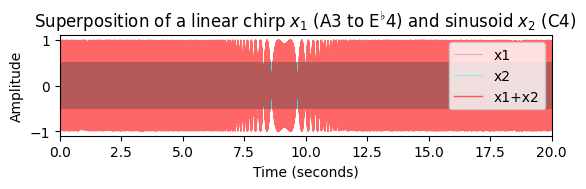

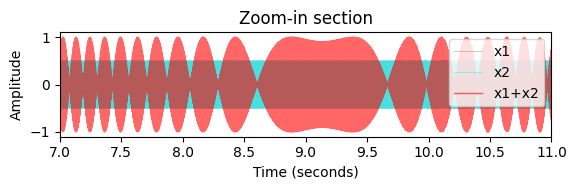

In [104]:
f_pitch = lambda p: 440 * 2 ** ((p - 69) / 12)

Fs = 4000
dur = 20
freq_start = f_pitch(57)   # A3
freq_end = f_pitch(63)     # Eflatp4
freq_sin = f_pitch(60)     # C4
x1, t, freq = generate_chirp_linear(dur=dur, freq_start=freq_start, freq_end=freq_end, amp=0.5, Fs=Fs)
x2, t = generate_sinusoid(dur=dur, Fs=Fs, amp=0.5, freq=freq_sin)

y = x1 + x2
ipd.display(ipd.Audio(y, rate=Fs))
plot_interference(x1, x2, t, xlim=[0, dur], ylim=[-1.1,1.1], 
    title=r'Superposition of a linear chirp $x_1$ (A3 to E$^\flat$4) and sinusoid $x_2$ (C4)');
plot_interference(x1, x2, t, xlim=[7, 11], ylim=[-1.1,1.1], title='Zoom-in section');

출처: https://www.audiolabs-erlangen.de/resources/MIR/FMP/C2/C2.html